# Homework 4. Moleculal dynamics simulation  of 2D soft-disk fluid

In this homework, you will use molecular dynamics to simulate the behavior of fluid consisting of soft disks in two dimensions. The particles in this fluid interact with each other via the pairwise potential of the following form: 

 $$  u(r_{ij})=\left\{
                \begin{array}{ll}
                  4\epsilon \left[ 
                  \left (
                  \frac{\sigma}{r_{ij} }
                  \right )^{12} 
                  -
                   \left (
                  \frac{\sigma}{r_{ij} }
                  \right )^{6} + 
                  \right ] + \epsilon,  \ r_{ij} < r_c\\
                  0, r_{ij} \geq r_c, r_c = 2^{1/6}\sigma
                \end{array}
              \right.
$$

For this model, we will use reduced MD units, such that $\sigma = 1 $, $  \epsilon=1$,  $k_b = 1$.
All the particles have unit mass.

$ r_c = 2^{1/6}\sigma $

**The homework consists of 5 tasks, 25 points total. You should work in groups of 3-4 people and submit one solution for each group within 3 weeks. You can use GitHub for collaboration.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#from numba import jit

## Task 1.  System initialization

1) Write a function that assigns coordinates of  N particles on a square grid inside a square box with side length L. This function should return a 2d array with coordinates for each particle. (1 pt)

2) Write a function that takes temperature as input and initializes particle velocities consistent with the given temperature. Make sure that the total momentum of the system is zero. (2 pt)


1) Initialization of the grid

In [2]:
def init_lattice(N_particles, L):        # Refernece: https://www.kite.com/python/answers/how-to-get-all-element-combinations-of-two-numpy-arrays-in-python
    '''N_particles... number of particels inside the fluid. It needs to be a square number, 
    else one can not build an equally distance square lattice.
    L... length of the box.
    '''
    nps = np.sqrt(N_particles)    #Calculates how many particles are in one row
    distance = L/(nps*2)
    init=np.linspace(distance,L-distance,int(nps))           #Generates an array with the number of particles in a row   
    grid_points=np.array(np.meshgrid(init,init)).T.reshape(-1, 2)
    grid_points=grid_points-L/2
    return grid_points

2) Initialize velocity

In [3]:
def init_velocity(T,N):
    v= np.random.normal(0,np.sqrt(T),(N,2))
    v = v - np.mean(v,axis=0)
    return v

## Task 2. Building MD code  


1) Write code to perform molecular dynamics simulation of your system according to the following algorithm:

 *  Initialize positions, velocities, and accelerations for your system.
 * For each modeling step:
      - Update coordinates using velocity Verlet algorithm. (1 pt)
      - Apply periodic boundary conditions to coordinates. (1pt)
      - Calculate the force acting on each particle and accelerations. Keep in mind minimum image convention! (4 pt)
      - Update velocities using velocity Verlet algorithm. (1pt)

In [4]:
def min_image(r_int,index): # Improve by vectorizing for loop
    r = r_int.copy()
    x = r[:,:1]
    y = r[:,1:]    
    for i in range(len(x)):
        if x[i] > L/2+r[index,0]:
            x[i] = x[i] - L
        elif x[i] < -L/2+r[index,0]:
            x[i] = x[i] + L
        else:
            x[i] = x[i]
        
    # updating y
    for i in range(len(y)):
        if y[i] > L/2+r[index,1]:
            y[i] = y[i] - L
        elif y[i] < -L/2+r[index,1]:
            y[i] = y[i] + L
        else:
            y[i] = y[i]
    pos_new = np.concatenate((x,y),axis=1)    
    return pos_new  

In [5]:
def LJ_trunc(N,position,L):
    forces = np.zeros((N, 2))    
    rc_squared = 2**(1/3)
    for i in range(N):
        force = np.zeros((N-i-1,2))
        pos = min_image(position,i)
        r_vec = pos[i]-pos[i + 1:]                    
        r_squared = np.sum(r_vec ** 2, axis=1)           # calculates [1/r12^2,1/r13^2,...]. Is like [:, np.newaxis] reshape(143,1)
        index = np.where(r_squared<rc_squared)
        r_squared_new = r_squared[index][:, np.newaxis]
        r_vec_new = r_vec[index,:]                                       #np.heaviside(2**(-1/3)-r_inv_squared,1)
        force[index,:] = 4*(12*1/r_squared_new**7 - 6*1/r_squared_new**4)*r_vec_new  # calculates array(F12,F13,...). np.heaviside(2**(-1/3)-r_inv_squared,1)
        forces[i] += np.sum(force, axis=0)                                # sums them up
        forces[i + 1:] -= force                                           # for next loop F21 is missing, but F21 =-F12 and we save is preventively
    return forces                                                       # F=a if m=1

In [6]:
def apply_pbc(L, position): # Improve by vectorizing for loop
    x = position[:,:1]
    y = position[:,1:]
    # updating x
    for i in range(len(x)):
        if x[i] > L/2:
            x[i] = x[i] - L
        elif x[i] < -L/2:
            x[i] = x[i] + L
        else:
            x[i] = x[i]
        
    # updating y
    for i in range(len(y)):
        if y[i] > L/2:
            y[i] = y[i] - L
        elif y[i] < -L/2:
            y[i] = y[i] + L
        else:
            y[i] = y[i]
        
    pos_new = np.concatenate((x,y),axis=1)    
    return pos_new

In [7]:
def valet_velocity(x_cur,v_cur,N,L,dt,force_cur,force):
    x_new = x_cur+v_cur*dt+1/2*force_cur*dt**2
    x_new = apply_pbc(L,x_new)
    force_new = force(N,x_new,L)
    v_new = v_cur+dt/2*(force_cur+force_new)
    return x_new, v_new, force_new

## Task 3. Simulations in the microcanonical ensemble

1) Use the code you wrote in task 3 to run MD simulation of a system with 36 particles in a square box with side length L = 6 for at least 5000 steps. Initialize velocities using T=1. Use integration step dt = 0.005. Save coordinates and velocities at each step to a file. (2 pt)

2) For each timestep, calculate and plot the following values as a function of time: $\sum_i^{N particles} V_x^i $, $\sum_y^{N particles} V_y^i $, $E_{total}$, $E_{potential}$, $E_{kinetic}$, temperature. Which of the these values should be conserved? Do your results match the prediction?  (3 pt)

3) Was the modeling time enough for the system to equilibrate? Explain.  (1 pt)


In [10]:
def md(N,L,x0,v0,force_cal,boundary,integrator,dt,nsteps):
    x = np.zeros((nsteps+1,N,2))
    v = np.zeros((nsteps+1,N,2))
    x[0]=x0
    v[0]=v0
    force_cur = force_cal(N,x0,L)
    
    for i in tqdm(range(nsteps)):    
        x[i+1], v[i+1], force_new = integrator(x[i],v[i],N,L,dt,force_cur,force_cal)
        force_cur = force_new
    return x, v

In [11]:
N = 36
L = 6
T = 1.0
x0 = init_lattice(N, L)
v0 = init_velocity(T,N)
x, v = md(N,L,x0,v0,LJ_trunc,apply_pbc,valet_velocity,nsteps=5000,dt=0.005)

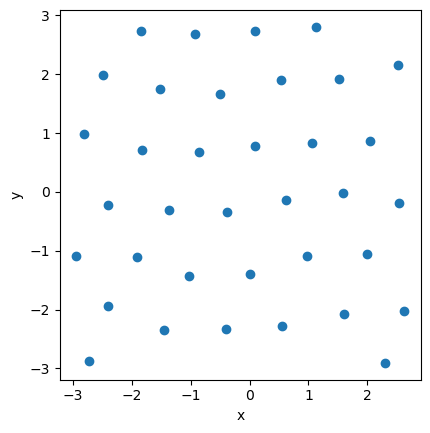

In [12]:
plt.plot(x[-1,:,:1],x[-1,:,1:],'o')
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
#plt.savefig('MD')
plt.show()

In [13]:
np.save('coordinate_trajectory.npy',x)
np.save('velocities.npy',v)

In [14]:
def energy_velocities(v,r,N):
    v_step = np.sum(v,axis=1)
    vx = v_step[:,:1]
    vy = v_step[:,1:]
    E_kin = np.sum(1/2*np.sum(v**2, axis=1), axis=1)  
    rc = 2**(1/6)
    E_pot_t = np.zeros(len(r))
    for n in tqdm(range(len(r))):
        position=r[n]
        E_pot=0
        for i in range(len(position)):
            pos = min_image(position,i)
            rij = np.linalg.norm(pos[i]-pos[i + 1:], axis = 1)
            index = np.where(rij<rc)
            r_inv = rij[index]**-6
            E_pot+=np.sum(4*(r_inv**2-r_inv)+1)
        E_pot_t[n] = E_pot
    E_tot = E_kin+E_pot_t
    temp = E_kin/N
    return vx , vy , E_kin, E_pot_t, E_tot, temp

In [15]:
vx, vy , E_kin, E_pot, E_tot, temp = energy_velocities( v,x,N)

100%|██████████████████████████████████████████████████████████████████████████████| 5001/5001 [01:24<00:00, 59.20it/s]


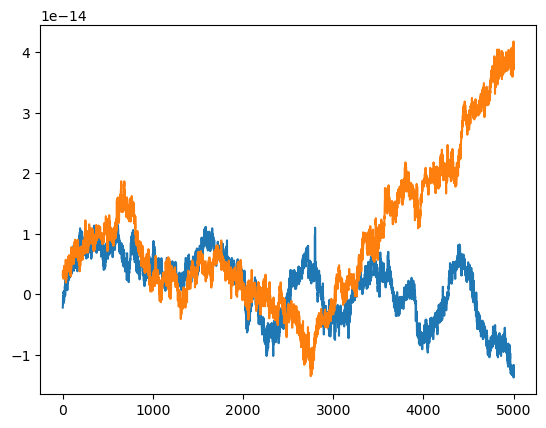

In [16]:
plt.plot(vx)
plt.plot(vy)
plt.xlabel(t)
plt.xlabel(velocities)
plt.show()

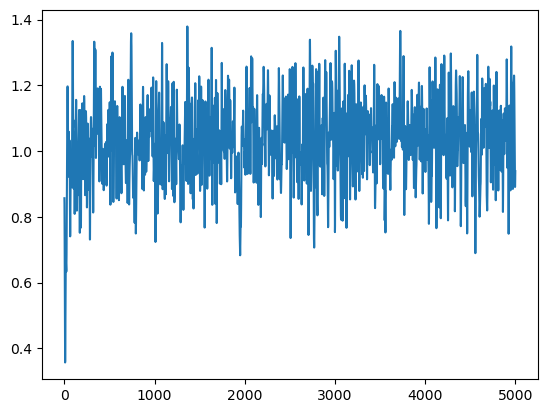

In [17]:
plt.plot(temp)
plt.xlabel(t)
plt.xlabel(temperature)
plt.show()

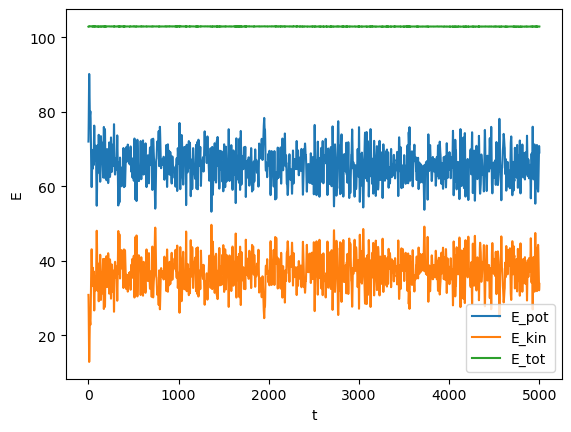

In [18]:
plt.plot(E_pot,label='E_pot')
plt.plot(E_kin,label='E_kin')
plt.plot(E_pot+E_kin,label='E_tot')
plt.xlabel('t')
plt.ylabel('E')
plt.legend()
#plt.savefig('energies')
plt.show()

Because we are in the microcanonical ensemble, the total energy should be conserved and as we can see in the plot above this is also the case.

We can see that the distance between the kinetic energy and the potential energy narrows and stabilizes around a certain value. Therefore we can conclude that the system has equilibrated.

## Task 4. Constant temperature molecular  dynamics

In this task, you will extend code from task 2 to run the simulation at a constant temperature using Langevin dynamics.

1) Implement integration of the Langevin equation. (2 pt)

2) Simulate cooling of the liquid with 144 particles in the box with L=12. First, run the simulation at T=1.4 for 2000 steps. Use final coordinates and velocities to start another simulation, this time with T=1.2.  Run this lower-temperature simulation for 2000 steps. Keep restarting the simulation, each time decreasing the temperature by 0.2. The final run should be performed at T=0.6  In all the simulations, use a constant friction coefficient of your choice. (2 pt)

3) Visualize several frames from a low-temperature fragment of the trajectory. These frames represent the microscopic structure of the frozen soft-disk liquid. Is the structure different from the initial square-grid arrangement? (1 pt)

Questions:

    1. How const. temp., but cooling?
    Cooling by changing temp.
    2. Is our langevin interator ok so? Is ok 
    3. How to choos gamma? Should by ok
    4. How to calculate the energy in 3? Ok
    5. How to choose R. because it says it has to be a number in 0,1, but also taht it is from a normal distribution? Ok
    6. How does the video code work? Ok

In [19]:
def langevin_old(x_cur,v_cur,N,L,dt,T, force_cur,force,gamma=10.0):
    a = np.exp(-gamma*dt)
    R = np.random.rand(N,2)
    v_m_half = v_cur-force_cur*dt/2                      #Is that true?
    v_p_half = v_m_half*a+force_cur*(1-a)/gamma+np.sqrt(T*(1-a**2))*R
    x_new = x_cur+v_p_half*dt
    x_new = apply_pbc(L,x_new)
    force_new = force(N,x_new,L)
    v_new = v_cur+dt/2*(force_cur+force_new)             #Is that true?
    return x_new, v_new, force_new

In [20]:
def langevin(x_cur,v_m_half,N,L,dt,T ,force_cur,force,gamma=0.1):
    a = np.exp(-gamma*dt)
    R = np.random.normal(0,1,(N,2))
    #R = np.random.normal(0,np.sqrt(2*gamma*T),(N,2))
    #R=R+abs(np.min(R,axis=0))                           #?
    #R=R/np.max(R)                                       #?
    #R=np.random.rand(N,2)
    
    v_p_half = v_m_half*a+force_cur*(1-a)/gamma+np.sqrt(T*(1-a**2))*R
    x_new = x_cur+v_p_half*dt
    x_new = apply_pbc(L,x_new)
    force_new = force(N,x_new,L)
    v_new = (v_p_half+v_m_half)/2             #Is that true?
    return x_new,v_new ,v_p_half, force_new

In [21]:
def md(N,L,x0,v0,T,force_cal,boundary,integrator,dt,nsteps):
    x = np.zeros((nsteps+1,N,2))
    v_half = np.zeros((nsteps+1,N,2))
    v_full = np.zeros((nsteps,N,2))
    x[0]=x0
    v_half[0]=v0
    force_cur = force_cal(N,x0,L)
    
    for i in tqdm(range(nsteps)):    
        x[i+1] ,v_full[i],v_half[i+1], force_new = integrator(x[i],v_half[i],N,L,dt,T,force_cur,force_cal)
        force_cur = force_new
    return x, v_half ,v_full

In [22]:
N = 36
L = 6
T = 1.4
x0 = init_lattice(N, L)
v0 = init_velocity(T,N)
x, v_half ,v_full = md(N,L,x0,v0,T,LJ_trunc,apply_pbc,langevin,nsteps=2000,dt=0.005)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.97it/s]


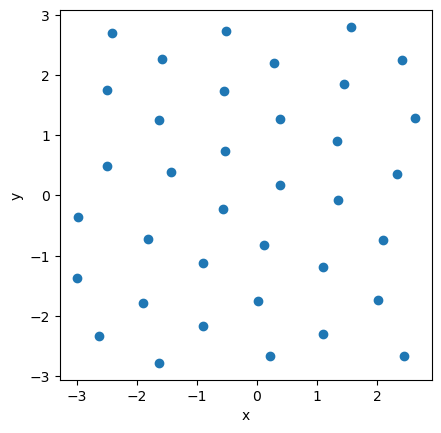

In [23]:
plt.plot(x[-1,:,:1],x[-1,:,1:],'o')
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
#plt.savefig('MD')
plt.show()

In [24]:
vx, vy , E_kin, E_pot, E_tot, temp = energy_velocities( v_full,x[1:],N)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 59.29it/s]


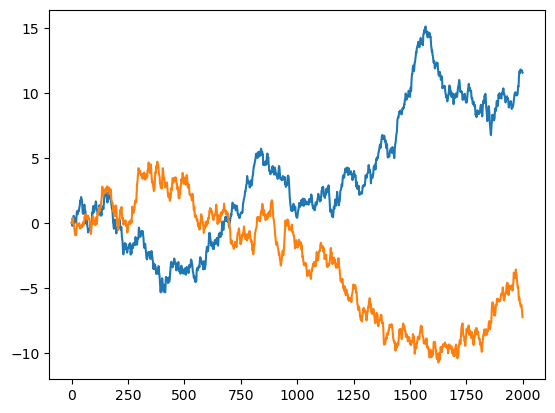

In [25]:
plt.plot(vx)
plt.plot(vy)
plt.show()

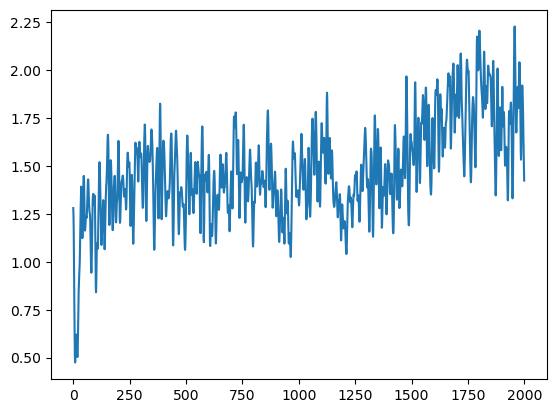

In [26]:
plt.plot(temp)
plt.show()

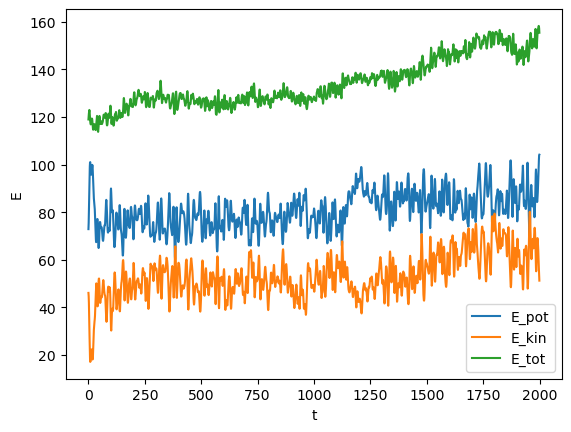

In [27]:
plt.plot(E_pot,label='E_pot')
plt.plot(E_kin,label='E_kin')
plt.plot(E_pot+E_kin,label='E_tot')
plt.xlabel('t')
plt.ylabel('E')
plt.legend()
#plt.savefig('energies')
plt.show()

In [ ]:
N = 144
L = 12
T = 1.4
x0 = init_lattice(N, L)
v0 = init_velocity(T,N)

lis_temp = [1.4,1.2,1.0,0.8,0.6]
for i in lis_temp:
    x, v_half ,v_full = md(N,L,x0,v0,i,LJ_trunc,apply_pbc,langevin,nsteps=2000,dt=0.005)
    x0=x[-1]
    v0=v_half[-1]

 41%|████████████████████████████████▌                                              | 825/2000 [03:21<04:41,  4.17it/s]

In [ ]:
np.save('coordinate_trajectory_cooling.npy',x)
np.save('velocities_cooling.npy',v_full)

In [ ]:
plt.plot(x[-1,:,:1],x[-1,:,1:],'o')
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
#plt.savefig('MD')
plt.show()

In [ ]:
vx, vy , E_kin, E_pot, E_tot, temp = energy_velocities( v_full,x[1:],N)

In [ ]:
plt.plot(vx)
plt.plot(vy)
plt.show()

In [ ]:
plt.plot(temp)
plt.show()

In [ ]:
plt.plot(E_pot,label='E_pot')
plt.plot(E_kin,label='E_kin')
plt.plot(E_pot+E_kin,label='E_tot')
plt.xlabel('t')
plt.ylabel('E')
plt.legend()
#plt.savefig('energies')
plt.show()

In [ ]:
#from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook
###
L = 12
sigma = 1
nx = 2
ny = 2
trajectory = np.load('coordinate_trajectory_cooling.npy')
trajectory = trajectory[1995:]
###
fig, ax = plt.subplots(1,1, figsize=(6,6))
low_x = -L/2
high_x = L/2 + L*(nx-1)
low_y = -L/2
high_y  =L/2 + L*(ny-1)
ax.set_xlim(low_x, high_x)
ax.set_ylim(low_y, high_y)
ax.set_aspect(1)
M = ax.transData.get_matrix()
scale = min(M[0,0], M[1,1])

def update(frame_ndx):
    ax.clear()
    for i in range(nx):
        for j in range(ny):
            ax.set_xlim(low_x, high_x)
            ax.set_ylim(low_y, high_y)
            ax.set_aspect(1)
            M = ax.transData.get_matrix()
            scale = min(M[0,0], M[1,1])
            ax.scatter(trajectory[frame_ndx][:, 0] + i*L, trajectory[frame_ndx][:, 1] + j*L,
                          s=(sigma*scale/2)**2, color='blue', edgecolor='darkblue')
    
animation = FuncAnimation(fig, update, interval=1)
plt.show()

We can observe a highly ordered hexagonal pattern.

## Task 5. Considerations when modeling realistic systems

It is easy to run a simulation that yields meaningless results when doing molecular dynamics simulation. To avoid this problem, one should know the properties and limitations of the algorithms used. To prevent some of the common pitfalls in the future, answer the following questions.

1) What is the maximum cut-off radius for nonbonded interactions in a periodic system with cubic box size L?  Explain your answer. (1 pt)

2) Can the Andersen thermostat be used to study dynamic properties of the system, such as diffusion coefficients. Why? (1 pt)

3) What is the purpose of the particle mesh Evald (PME) algorithm? Please briefly describe the method and a) why it is used, b) which caveats does it have, c) what are the alternatives (3 pt)

1) The maximum cutoff radius should be L/2, because with this radius we cover the elemte cell. If we would choose a larger cutoff radius we would exceed the elemte cell and thus calculate forces to partictles twice.